# Domain shift regression

This notebook is a brief template to generate synthetic gadolinium-enhanced T1w brain image from FLAIR, T1w and T2w images.

For the sake of speed, a 2D dataset has been created by taking slices from the 3D BRATS brain tumor dataset.

The dataset comes from http://medicaldecathlon.com/.  

A number of blanks need to be filled in to get some results, and then improvements can be made to improve upon these!

## Todo
* Decide upon a network, loss function, optimzer, etc.
* Add a validation section

## Improvements
Can you use any techniques to improve upon results or accelerate the training (e.g., AMP)?

## Extension
Can you get reasonable results once certain channels from the input (e.g., the T2w) have been removed?

## Setup environment

In [1]:
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
# Copyright 2021 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import random
from tqdm import trange
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
from monai.apps import download_and_extract
from monai.networks.nets import AutoEncoder
from monai.config import print_config
from monai.data import Dataset, DataLoader, partition_dataset
from monai.networks import eval_mode
from monai.transforms import (
    Compose,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    rescale_array,
    ScaleIntensityd,
    RandFlipd,
    RandZoomd,
)
from monai.utils import set_determinism

print_config()
set_determinism(0)

MONAI version: 0.7.0rc3+7.g3a597cfb
Numpy version: 1.21.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 3a597cfbd2b022a10b20470f596c03028371c5a6

Optional dependencies:
Pytorch Ignite version: 0.4.5
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.3.1
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0+cu102
tqdm version: 4.61.2
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.0
einops version: 0.3.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/rich/Documents/Data/MONAI


In [4]:
data_dir = os.path.join(root_dir, "brain_2d")
resource = "https://drive.google.com/uc?id=17f4J_rU5pi1zRmxMe5OwljyT3tlBf6qI"
compressed_file = os.path.join(root_dir, "brain_2d.tar.gz")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)

In [5]:
input_ims = sorted(glob(os.path.join(data_dir, "*input.npy")))
output_ims = sorted(glob(os.path.join(data_dir, "*GT_output.npy")))
data = [{"input": i, "output": o} for i, o in zip(input_ims, output_ims)]
print("number data points", len(data))
print("example", data[0])

number data points 7500
example {'input': '/home/rich/Documents/Data/MONAI/brain_2d/0_input.npy', 'output': '/home/rich/Documents/Data/MONAI/brain_2d/0_GT_output.npy'}


In [6]:
class ChannelWiseScaleIntensityd(MapTransform):
    """Perform channel-wise intensity normalisation."""
    def __init__(self, keys):
        super().__init__(keys)
    def __call__(self, d):
        for key in self.keys:
            for idx, channel in enumerate(d[key]):
                d[key][idx] = rescale_array(channel)
        return d

keys = ["input", "output"]
train_transforms = Compose([
    LoadImaged(keys),
    ChannelWiseScaleIntensityd("input"),
    ScaleIntensityd("output"),
    RandFlipd(keys, spatial_axis=0, prob=0.5),
    RandZoomd(keys, min_zoom=0.9, max_zoom=1.1, prob=0.5),
    EnsureTyped(keys),
])
val_transforms = Compose([
    LoadImaged(keys),
    ChannelWiseScaleIntensityd("input"),
    ScaleIntensityd("output"),
    EnsureTyped(keys),
])

t = train_transforms(data[0])
print(t["input"].shape, t["output"].shape)
in_channels, out_channels = t["input"].shape[0], t["output"].shape[0]

torch.Size([3, 240, 240]) torch.Size([1, 240, 240])


In [7]:
# split data into 80% and 20% for training and validation, respectively
train_data, val_data = partition_dataset(data, (8, 2), shuffle=True)
print("num train data points:", len(train_data))
print("num val data points:", len(val_data))
batch_size = 10
num_workers = 10
train_ds = Dataset(train_data, train_transforms)
train_dl = DataLoader(train_ds, num_workers=num_workers, batch_size=batch_size, shuffle=True)
val_ds = Dataset(val_data, val_transforms)
val_dl = DataLoader(val_ds, num_workers=num_workers, batch_size=batch_size, shuffle=True)

num train data points: 6000
num val data points: 1500


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create loss fn and optimiser
max_epochs = 10
model = AutoEncoder(
    dimensions=2,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=(4, 8, 16, 32),
    strides=(2, 2, 2, 2),
).to(device)

# Create loss fn and optimiser
loss_function = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

epoch_losses = []

t = trange(max_epochs, desc=f"epoch 0, avg loss: inf", leave=True)
for epoch in t:
    model.train()
    epoch_loss = 0
    step = 0
    for batch in train_dl:
        step += 1
        inputs, outputs_gt = batch["input"].to(device), batch["output"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, outputs_gt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_losses.append(epoch_loss)
    t.set_description(f"epoch {epoch + 1}, average loss: {epoch_loss:.4f}")

epoch 10, average loss: 0.0042: 100%|██████████| 10/10 [01:49<00:00, 11.00s/it]


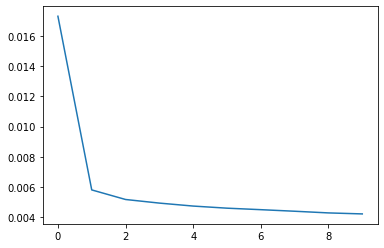

In [10]:
plt.plot(epoch_losses);

In [11]:
%matplotlib inline
def imshows(ims):
    """Visualises a list of dictionaries.

    Each key of the dictionary will be used as a column, and
    each element of the list will be a row.
    """
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white')
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            # If RGB, put to end. Else, average across channel dim
            if im.ndim > 2:
                im = np.moveaxis(im, 0, -1) if im.shape[0] == 3 else np.mean(im, axis=0)

            ax = axes[j] if len(ims) == 1 else axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im)
            ax.axis("off")

to_imshow = []

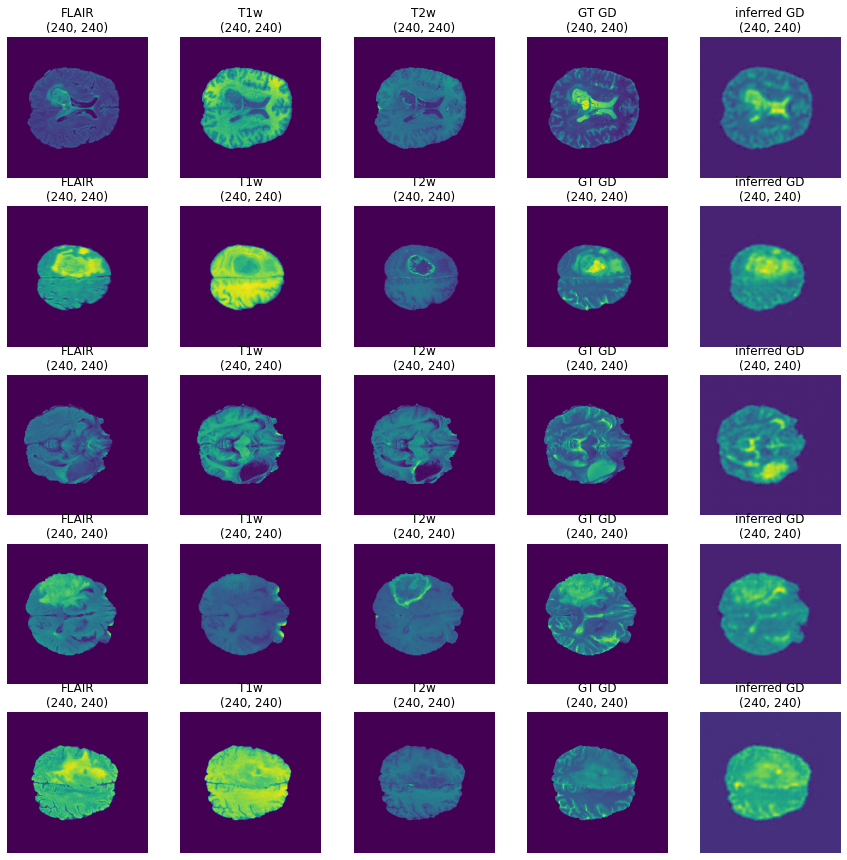

In [12]:
_ = model.eval()

for idx in np.random.choice(len(val_ds), size=5, replace=False):
    rand_data = val_ds[idx]
    rand_input, rand_output_gt = rand_data["input"], rand_data["output"]
    rand_output = model(rand_input.to(device)[None])[0]
    to_imshow.append(
        {
            "FLAIR": rand_input[0],
            "T1w": rand_input[1],
            "T2w": rand_input[2],
            "GT GD": rand_output_gt,
            "inferred GD": rand_output,
        }
    )
imshows(to_imshow)